In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import os, shutil
import time
import scipy
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

np.random.seed(123)
from keras.models import load_model


Using TensorFlow backend.


In [91]:
df = pd.read_csv('model_data.csv')

In [92]:
df.shape[0]

376426

## Binning Ages into Ranges

In [95]:
#Lowering the amount of images by removing lower quality face pictures, since too many pictures at the moment
df = df.loc[df.face_score > 2.5]

In [96]:
df.shape[0]

248099

In [97]:
def viewcount(df, first_age, second_age):
    return df.loc[(df.age >= first_age)&(df.age < second_age)].count()[0]

def classcount(df):
    for i in list(range(10, 80, 5)):
        print("Number of instances between {} and {} is: ".format(i, i+5) ,viewcount(df, i, i +5))
        if i == 75:
            print("Number of classes:", (i-10)/5 + 1)

classcount(df)

Number of instances between 10 and 15 is:  3520
Number of instances between 15 and 20 is:  9530
Number of instances between 20 and 25 is:  26272
Number of instances between 25 and 30 is:  38153
Number of instances between 30 and 35 is:  42182
Number of instances between 35 and 40 is:  38434
Number of instances between 40 and 45 is:  29270
Number of instances between 45 and 50 is:  21589
Number of instances between 50 and 55 is:  13910
Number of instances between 55 and 60 is:  9674
Number of instances between 60 and 65 is:  6918
Number of instances between 65 and 70 is:  4284
Number of instances between 70 and 75 is:  2692
Number of instances between 75 and 80 is:  1671
Number of classes: 14.0


In [98]:
age_ranges = ["[{0} - {1})".format(age, age + 5) for age in range(10, 70, 5)]
age_ranges.append("[70 - 80)") #Combining 70-80 into one class, since not enough samples compared to other ranges

In [99]:
age_ranges

['[10 - 15)',
 '[15 - 20)',
 '[20 - 25)',
 '[25 - 30)',
 '[30 - 35)',
 '[35 - 40)',
 '[40 - 45)',
 '[45 - 50)',
 '[50 - 55)',
 '[55 - 60)',
 '[60 - 65)',
 '[65 - 70)',
 '[70 - 80)']

In [100]:
df.dtypes

dob                    int64
photo_taken            int64
full_path             object
gender               float64
name                  object
face_location         object
face_score           float64
second_face_score    float64
age                    int64
dtype: object

In [101]:
bins = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 80]
df['age_range'] = pd.cut(df.age, 
                         bins= bins, 
                         labels= age_ranges, 
                         right= False)

C:\Users\ar344\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [102]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,age,age_range
1,1899,1970,data/imdb/01/nm0000001_rm3343756032_1899-5-10_...,1.0,['Fred Astaire'],[[477.184 100.352 622.592 245.76 ]],2.543198,1.852008,71,[70 - 80)
2,1899,1968,data/imdb/01/nm0000001_rm577153792_1899-5-10_1...,1.0,['Fred Astaire'],[[114.96964309 114.96964309 451.68657236 451.6...,3.455579,2.985660,69,[65 - 70)
5,1924,1991,data/imdb/02/nm0000002_rm1075631616_1924-9-16_...,0.0,['Lauren Bacall'],[[ 686.67682059 458.46721373 1198.10043604 9...,3.490563,1.345335,67,[65 - 70)
6,1924,1974,data/imdb/02/nm0000002_rm221957120_1924-9-16_1...,0.0,['Lauren Bacall'],[[3173.14469259 401.04083657 4059.15207489 12...,4.096431,NaN,50,[50 - 55)
7,1924,1974,data/imdb/02/nm0000002_rm238734336_1924-9-16_1...,0.0,['Lauren Bacall'],[[2135.21778394 765.85377998 3499.48578791 21...,4.865421,NaN,50,[50 - 55)


In [103]:
df.age_range.value_counts()

[30 - 35)    42182
[35 - 40)    38434
[25 - 30)    38153
[40 - 45)    29270
[20 - 25)    26272
[45 - 50)    21589
[50 - 55)    13910
[55 - 60)     9674
[15 - 20)     9530
[60 - 65)     6918
[70 - 80)     4363
[65 - 70)     4284
[10 - 15)     3520
Name: age_range, dtype: int64

## Class Imbalances

In [104]:
classes[0]

'[70 - 80)'

In [105]:
classes

[[70 - 80), [65 - 70), [50 - 55), [60 - 65), [25 - 30), ..., [35 - 40), [40 - 45), [20 - 25), [10 - 15), [15 - 20)]
Length: 13
Categories (13, object): [[10 - 15) < [15 - 20) < [20 - 25) < [25 - 30) ... [55 - 60) < [60 - 65) < [65 - 70) < [70 - 80)]

In [106]:
len(df[df["age_range"] == a])

4363

In [107]:
from sklearn.utils import resample
classes = df.age_range.unique()

#function to create new df containing specific class 
def down_sample(df, c, n_samples):
    if df[df["age_range"] == c].shape[0] > 7000:
        new_df = df[df["age_range"] == c]
        down_sampled_df = resample(new_df, replace = False, n_samples = n_samples, random_state = 123)
        return down_sampled_df



In [108]:
balanced_df = df[df.age_range == '[60 - 65)']
for c in classes:
      balanced_df = pd.concat([balanced_df, down_sample(df, c, 7000)])
    

In [109]:
balanced_df.age_range.value_counts()

[55 - 60)    7000
[50 - 55)    7000
[45 - 50)    7000
[40 - 45)    7000
[35 - 40)    7000
[30 - 35)    7000
[25 - 30)    7000
[20 - 25)    7000
[15 - 20)    7000
[60 - 65)    6918
[70 - 80)       0
[65 - 70)       0
[10 - 15)       0
Name: age_range, dtype: int64

In [110]:
#balanced_df = pd.concat([balanced_df, df[df['age_range'] == '[60 - 65)']])
balanced_df = pd.concat([balanced_df, df[df['age_range'] == '[65 - 70)']])
balanced_df = pd.concat([balanced_df, df[df['age_range'] == '[70 - 80)']])

In [112]:
ten_15_df = resample(df[df['age_range'] == "[10 - 15)"], n_samples = 7000, random_state = 123)
balanced_df = pd.concat([balanced_df, ten_15_df])

In [113]:
balanced_df.age_range.value_counts()

[55 - 60)    7000
[50 - 55)    7000
[45 - 50)    7000
[40 - 45)    7000
[35 - 40)    7000
[30 - 35)    7000
[25 - 30)    7000
[20 - 25)    7000
[15 - 20)    7000
[10 - 15)    7000
[60 - 65)    6918
[70 - 80)    4363
[65 - 70)    4284
Name: age_range, dtype: int64

In [115]:
balanced_df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,age,age_range
8,1924,1988,data/imdb/02/nm0000002_rm2805435904_1924-9-16_...,0.0,['Lauren Bacall'],[[548.38500497 200.71600181 769.838507 422.1...,3.410720,1.196696,64,[60 - 65)
50,1915,1978,data/imdb/06/nm0000006_rm469283328_1915-8-29_1...,0.0,['Ingrid Bergman'],[[1200.14843604 287.31000858 1711.57205149 7...,3.472309,1.327453,63,[60 - 65)
131,1899,1961,data/imdb/10/nm0000010_rm3838294784_1899-7-17_...,1.0,['James Cagney'],[[843.07682567 211.53645642 999.93891798 368.3...,3.056761,2.392069,62,[60 - 65)
133,1899,1961,data/imdb/10/nm0000010_rm3922180864_1899-7-17_...,1.0,['James Cagney'],[[762.49973432 85.63152604 846.08526036 169.2...,3.173383,1.725404,62,[60 - 65)
135,1899,1961,data/imdb/10/nm0000010_rm3972512512_1899-7-17_...,1.0,['James Cagney'],[[394.53640901 163.05793312 601.84403731 370.3...,2.723845,NaN,62,[60 - 65)


In [116]:
balanced_df.shape

(85565, 10)

In [117]:
#Do not run this again
balanced_df.to_csv('balanced_df.csv', index= False)

## Preprocess Images 

In [3]:
balanced_df = pd.read_csv('balanced_df.csv')

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(balanced_df['full_path'], 
                                                    balanced_df['age_range'], 
                                                    test_size = 0.20,
                                                    random_state = 42, 
                                                    stratify = balanced_df['age_range'],
                                                   )

In [5]:
y_train.value_counts()

[25 - 30)    5600
[50 - 55)    5600
[55 - 60)    5600
[40 - 45)    5600
[20 - 25)    5600
[15 - 20)    5600
[35 - 40)    5600
[10 - 15)    5600
[45 - 50)    5600
[30 - 35)    5600
[60 - 65)    5534
[70 - 80)    3491
[65 - 70)    3427
Name: age_range, dtype: int64

In [151]:
y_test.value_counts()

[55 - 60)    1400
[50 - 55)    1400
[45 - 50)    1400
[40 - 45)    1400
[35 - 40)    1400
[30 - 35)    1400
[25 - 30)    1400
[20 - 25)    1400
[15 - 20)    1400
[10 - 15)    1400
[60 - 65)    1384
[70 - 80)     872
[65 - 70)     857
Name: age_range, dtype: int64

In [6]:
training_dict = {'full_path': X_train, 'age_range': y_train}
testing_dict = {'full_path': X_test, 'age_range': y_test}
training_df = pd.DataFrame(training_dict)
testing_df = pd.DataFrame(testing_dict)

In [7]:
training_df.head()

,full_path,age_range
61202,data/wiki/86/3772886_1969-06-28_1990.jpg,[20 - 25)
58400,data/wiki/76/35119476_1990-08-02_2011.jpg,[20 - 25)
43488,data/wiki/09/756509_1975-11-05_2010.jpg,[35 - 40)
23200,data/imdb/55/nm0004755_rm2988161536_1978-5-12_...,[30 - 35)
69451,data/imdb/35/nm0507535_rm910802688_1989-6-27_2...,[15 - 20)


In [8]:
datagen = ImageDataGenerator(rescale = 1./255., validation_split= 0.1) 
test_datagen = ImageDataGenerator(rescale = 1./255.)

In [9]:
print(1./255)
print(1./255.)

0.00392156862745098
0.00392156862745098


In [67]:
#Creating seperate generators for testing, validation, and testing 
train_generator = datagen.flow_from_dataframe(training_df, 
                                              x_col= 'full_path',
                                              y_col= "age_range",
                                              target_size = (160, 160),
                                              batch_size = 200,
                                              seed = 123,
                                              subset = 'training')
                                             

validation_generator = datagen.flow_from_dataframe(training_df, 
                                                   x_col= 'full_path',
                                                   y_col = 'age_range',
                                                   target_size = (160, 160),
                                                   batch_size = 200,
                                                   subset = 'validation')



test_generator = test_datagen.flow_from_dataframe(testing_df,
                                                  x_col= 'full_path',
                                                  y_col= 'age_range',
                                                  target_size = (160, 160),
                                                  shuffle = False,
                                                  batch_size = 200,
                                                  seed = 123)


Found 59110 images belonging to 13 classes.
Found 6567 images belonging to 13 classes.
Found 16860 images belonging to 13 classes.


In [267]:
training_df.shape[0]

68452

## Modeling: Transfer Learning Using VGG 16 Only Training Classification Layers

In [6]:
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Activation, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.models import Sequential
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam, sgd
from keras.activations import relu, tanh, sigmoid

from sklearn.metrics import confusion_matrix

In [58]:
from keras.applications import VGG16
cnn_base_vgg16 = VGG16(include_top = False, weights = 'imagenet', input_shape= (160, 160, 3))

In [59]:
cnn_base_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0         
__________

In [60]:
complete_model = cnn_base_vgg16.output
complete_model = GlobalAveragePooling2D()(complete_model)

complete_model = Dense(1024)(complete_model)
complete_model = BatchNormalization()(complete_model)
complete_model = Activation('tanh')(complete_model)
complete_model = Dropout(rate= 0.4)(complete_model)


complete_model = Dense(256)(complete_model)
complete_model = BatchNormalization()(complete_model)
complete_model = Activation('tanh')(complete_model)

complete_model = Dense(256)(complete_model)
complete_model = BatchNormalization()(complete_model)
complete_model = Activation('tanh')(complete_model)

preds = Dense(13, activation= "softmax")(complete_model) #Final layer with softmax activation

In [61]:
cnn_base_vgg16.input

<tf.Tensor 'input_4:0' shape=(?, 160, 160, 3) dtype=float32>

In [62]:
model = Model(inputs = cnn_base_vgg16.input, outputs = preds)

In [295]:
len(model.layers)

30

In [170]:
model.layers

In [189]:
model.layers[19:]

In [63]:
for layer in model.layers[:19]:
    layer.trainable = False
for layer in model.layers[19:]:
    layer.trainable = True

In [65]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['acc'])

In [282]:
cnn_base_vgg16.layers[0].input

<tf.Tensor 'input_6:0' shape=(?, 160, 160, 3) dtype=float32>

In [ ]:
training_df.full_path.iloc[0]

In [68]:
import datetime
t1 = datetime.datetime.now()

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs= 30,
                    verbose= 1,
)

t2 = datetime.datetime.now()
print(t2-t1)

Epoch 1/30
  7/295 [..............................] - ETA: 6:16 - loss: 2.8719 - acc: 0.0800

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

103/295 [=========>....................] - ETA: 2:13 - loss: 2.7408 - acc: 0.0921

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

144/295 [=============>................] - ETA: 1:42 - loss: 2.7135 - acc: 0.0952

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

151/295 [==============>...............] - ETA: 1:37 - loss: 2.7107 - acc: 0.0955

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

161/295 [===============>..............] - ETA: 1:30 - loss: 2.7052 - acc: 0.0965

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

162/295 [===============>..............] - ETA: 1:30 - loss: 2.7050 - acc: 0.0964

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

164/295 [===============>..............] - ETA: 1:28 - loss: 2.7046 - acc: 0.0963

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

169/295 [================>.............] - ETA: 1:25 - loss: 2.7032 - acc: 0.0962

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

195/295 [==================>...........] - ETA: 1:07 - loss: 2.6896 - acc: 0.0986

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

220/295 [=====================>........] - ETA: 50s - loss: 2.6810 - acc: 0.0998

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

268/295 [==========================>...] - ETA: 17s - loss: 2.6647 - acc: 0.1016

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.6566 - acc: 0.1027

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 217s 735ms/step - loss: 2.6563 - acc: 0.1028 - val_loss: 2.4988 - val_acc: 0.1239
Epoch 2/30
  1/295 [..............................] - ETA: 15:09 - loss: 2.5683 - acc: 0.1182

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 32/295 [==>...........................] - ETA: 3:11 - loss: 2.5501 - acc: 0.1173

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 44/295 [===>..........................] - ETA: 2:57 - loss: 2.5596 - acc: 0.1159

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 62/295 [=====>........................] - ETA: 2:40 - loss: 2.5568 - acc: 0.1151

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 77/295 [======>.......................] - ETA: 2:28 - loss: 2.5553 - acc: 0.1150

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 82/295 [=======>......................] - ETA: 2:25 - loss: 2.5553 - acc: 0.1153

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

137/295 [============>.................] - ETA: 1:45 - loss: 2.5451 - acc: 0.1169

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

143/295 [=============>................] - ETA: 1:41 - loss: 2.5440 - acc: 0.1171

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

144/295 [=============>................] - ETA: 1:40 - loss: 2.5439 - acc: 0.1170

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

194/295 [==================>...........] - ETA: 1:07 - loss: 2.5396 - acc: 0.1171

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.5305 - acc: 0.1185

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 219s 744ms/step - loss: 2.5304 - acc: 0.1184 - val_loss: 2.4718 - val_acc: 0.1278
Epoch 3/30
 69/295 [======>.......................] - ETA: 2:26 - loss: 2.4940 - acc: 0.1267

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 82/295 [=======>......................] - ETA: 2:18 - loss: 2.4905 - acc: 0.1295

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 86/295 [=======>......................] - ETA: 2:15 - loss: 2.4901 - acc: 0.1298

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 99/295 [=========>....................] - ETA: 2:07 - loss: 2.4892 - acc: 0.1295

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

113/295 [==========>...................] - ETA: 1:58 - loss: 2.4888 - acc: 0.1298

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

136/295 [============>.................] - ETA: 1:43 - loss: 2.4882 - acc: 0.1300

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

140/295 [=============>................] - ETA: 1:40 - loss: 2.4881 - acc: 0.1302

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

166/295 [===============>..............] - ETA: 1:23 - loss: 2.4868 - acc: 0.1294

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

228/295 [======================>.......] - ETA: 43s - loss: 2.4870 - acc: 0.1286

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

233/295 [======================>.......] - ETA: 40s - loss: 2.4874 - acc: 0.1284

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

244/295 [=======================>......] - ETA: 33s - loss: 2.4869 - acc: 0.1288

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.4846 - acc: 0.1294

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 722ms/step - loss: 2.4845 - acc: 0.1295 - val_loss: 2.4549 - val_acc: 0.1302
Epoch 4/30
 89/295 [========>.....................] - ETA: 2:14 - loss: 2.4708 - acc: 0.1334

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 96/295 [========>.....................] - ETA: 2:09 - loss: 2.4723 - acc: 0.1319

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

123/295 [===========>..................] - ETA: 1:52 - loss: 2.4684 - acc: 0.1333

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

147/295 [=============>................] - ETA: 1:36 - loss: 2.4675 - acc: 0.1327

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

177/295 [=================>............] - ETA: 1:16 - loss: 2.4650 - acc: 0.1331

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

203/295 [===================>..........] - ETA: 59s - loss: 2.4634 - acc: 0.1335 

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

215/295 [====================>.........] - ETA: 52s - loss: 2.4628 - acc: 0.1333

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

242/295 [=======================>......] - ETA: 34s - loss: 2.4616 - acc: 0.1332

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

244/295 [=======================>......] - ETA: 33s - loss: 2.4615 - acc: 0.1334

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

269/295 [==========================>...] - ETA: 16s - loss: 2.4601 - acc: 0.1343

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

274/295 [==========================>...] - ETA: 13s - loss: 2.4601 - acc: 0.1343

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 724ms/step - loss: 2.4593 - acc: 0.1347 - val_loss: 2.4557 - val_acc: 0.1337
Epoch 5/30
 25/295 [=>............................] - ETA: 2:53 - loss: 2.4562 - acc: 0.1278

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 28/295 [=>............................] - ETA: 2:51 - loss: 2.4597 - acc: 0.1271

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 74/295 [======>.......................] - ETA: 2:24 - loss: 2.4478 - acc: 0.1391

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

170/295 [================>.............] - ETA: 1:21 - loss: 2.4440 - acc: 0.1387

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

177/295 [=================>............] - ETA: 1:17 - loss: 2.4433 - acc: 0.1382

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

179/295 [=================>............] - ETA: 1:15 - loss: 2.4433 - acc: 0.1381

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

187/295 [==================>...........] - ETA: 1:10 - loss: 2.4434 - acc: 0.1380

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

191/295 [==================>...........] - ETA: 1:07 - loss: 2.4437 - acc: 0.1379

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

226/295 [=====================>........] - ETA: 45s - loss: 2.4425 - acc: 0.1390

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

245/295 [=======================>......] - ETA: 32s - loss: 2.4417 - acc: 0.1394

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

277/295 [===========================>..] - ETA: 11s - loss: 2.4408 - acc: 0.1402

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.4403 - acc: 0.1401

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 723ms/step - loss: 2.4402 - acc: 0.1402 - val_loss: 2.4364 - val_acc: 0.1365
Epoch 6/30
 62/295 [=====>........................] - ETA: 2:31 - loss: 2.4382 - acc: 0.1415

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

103/295 [=========>....................] - ETA: 2:04 - loss: 2.4327 - acc: 0.1438

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

105/295 [=========>....................] - ETA: 2:03 - loss: 2.4316 - acc: 0.1444

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

174/295 [================>.............] - ETA: 1:18 - loss: 2.4315 - acc: 0.1447

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

177/295 [=================>............] - ETA: 1:16 - loss: 2.4317 - acc: 0.1442

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

211/295 [====================>.........] - ETA: 54s - loss: 2.4312 - acc: 0.1441

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

218/295 [=====================>........] - ETA: 50s - loss: 2.4313 - acc: 0.1445

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

255/295 [========================>.....] - ETA: 26s - loss: 2.4287 - acc: 0.1455

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

264/295 [=========================>....] - ETA: 20s - loss: 2.4286 - acc: 0.1453

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

287/295 [============================>.] - ETA: 5s - loss: 2.4283 - acc: 0.1450

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

288/295 [============================>.] - ETA: 4s - loss: 2.4285 - acc: 0.1450

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.4280 - acc: 0.1449

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 722ms/step - loss: 2.4278 - acc: 0.1450 - val_loss: 2.4371 - val_acc: 0.1428
Epoch 7/30
 34/295 [==>...........................] - ETA: 2:48 - loss: 2.4130 - acc: 0.1519

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 46/295 [===>..........................] - ETA: 2:41 - loss: 2.4085 - acc: 0.1547

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 49/295 [===>..........................] - ETA: 2:39 - loss: 2.4101 - acc: 0.1539

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 78/295 [======>.......................] - ETA: 2:20 - loss: 2.4140 - acc: 0.1513

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

109/295 [==========>...................] - ETA: 2:00 - loss: 2.4184 - acc: 0.1497

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

149/295 [==============>...............] - ETA: 1:35 - loss: 2.4185 - acc: 0.1483

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

155/295 [==============>...............] - ETA: 1:31 - loss: 2.4172 - acc: 0.1483

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

176/295 [================>.............] - ETA: 1:17 - loss: 2.4173 - acc: 0.1485

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

221/295 [=====================>........] - ETA: 48s - loss: 2.4172 - acc: 0.1479

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

248/295 [========================>.....] - ETA: 30s - loss: 2.4162 - acc: 0.1478

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

270/295 [==========================>...] - ETA: 16s - loss: 2.4161 - acc: 0.1480

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.4162 - acc: 0.1486

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 723ms/step - loss: 2.4164 - acc: 0.1485 - val_loss: 2.4280 - val_acc: 0.1382
Epoch 8/30
  2/295 [..............................] - ETA: 3:12 - loss: 2.3737 - acc: 0.1675

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 27/295 [=>............................] - ETA: 2:51 - loss: 2.3920 - acc: 0.1513

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 65/295 [=====>........................] - ETA: 2:29 - loss: 2.4058 - acc: 0.1500

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 82/295 [=======>......................] - ETA: 2:18 - loss: 2.4059 - acc: 0.1495

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 89/295 [========>.....................] - ETA: 2:13 - loss: 2.4042 - acc: 0.1494

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

153/295 [==============>...............] - ETA: 1:32 - loss: 2.4045 - acc: 0.1493

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

168/295 [================>.............] - ETA: 1:22 - loss: 2.4070 - acc: 0.1491

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

227/295 [======================>.......] - ETA: 44s - loss: 2.4078 - acc: 0.1491

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

233/295 [======================>.......] - ETA: 40s - loss: 2.4081 - acc: 0.1488

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

238/295 [=======================>......] - ETA: 37s - loss: 2.4085 - acc: 0.1490

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

262/295 [=========================>....] - ETA: 21s - loss: 2.4080 - acc: 0.1491

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.4062 - acc: 0.1504

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 722ms/step - loss: 2.4062 - acc: 0.1505 - val_loss: 2.4412 - val_acc: 0.1335
Epoch 9/30
  4/295 [..............................] - ETA: 3:10 - loss: 2.4062 - acc: 0.1587

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

  9/295 [..............................] - ETA: 2:57 - loss: 2.4152 - acc: 0.1515

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 84/295 [=======>......................] - ETA: 2:17 - loss: 2.4024 - acc: 0.1559

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 93/295 [========>.....................] - ETA: 2:11 - loss: 2.4040 - acc: 0.1553

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

140/295 [=============>................] - ETA: 1:40 - loss: 2.4030 - acc: 0.1542

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

151/295 [==============>...............] - ETA: 1:33 - loss: 2.4033 - acc: 0.1537

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

154/295 [==============>...............] - ETA: 1:31 - loss: 2.4033 - acc: 0.1539

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

191/295 [==================>...........] - ETA: 1:07 - loss: 2.4026 - acc: 0.1528

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

206/295 [===================>..........] - ETA: 57s - loss: 2.4017 - acc: 0.1531

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

249/295 [========================>.....] - ETA: 29s - loss: 2.4013 - acc: 0.1527

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

266/295 [==========================>...] - ETA: 18s - loss: 2.4015 - acc: 0.1530

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.4010 - acc: 0.1527

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 722ms/step - loss: 2.4011 - acc: 0.1526 - val_loss: 2.4284 - val_acc: 0.1379
Epoch 10/30
  5/295 [..............................] - ETA: 3:10 - loss: 2.4223 - acc: 0.1540

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 14/295 [>.............................] - ETA: 2:57 - loss: 2.4026 - acc: 0.1480

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

101/295 [=========>....................] - ETA: 2:06 - loss: 2.3929 - acc: 0.1585

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

165/295 [===============>..............] - ETA: 1:24 - loss: 2.3948 - acc: 0.1560

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

166/295 [===============>..............] - ETA: 1:24 - loss: 2.3951 - acc: 0.1559

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

180/295 [=================>............] - ETA: 1:14 - loss: 2.3963 - acc: 0.1552

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

211/295 [====================>.........] - ETA: 54s - loss: 2.3962 - acc: 0.1558

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

218/295 [=====================>........] - ETA: 50s - loss: 2.3960 - acc: 0.1559

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

244/295 [=======================>......] - ETA: 33s - loss: 2.3971 - acc: 0.1551

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

258/295 [=========================>....] - ETA: 24s - loss: 2.3969 - acc: 0.1549

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

264/295 [=========================>....] - ETA: 20s - loss: 2.3963 - acc: 0.1549

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3951 - acc: 0.1560

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 722ms/step - loss: 2.3950 - acc: 0.1562 - val_loss: 2.4192 - val_acc: 0.1403
Epoch 11/30
 32/295 [==>...........................] - ETA: 2:49 - loss: 2.3884 - acc: 0.1534

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 40/295 [===>..........................] - ETA: 2:44 - loss: 2.3877 - acc: 0.1514

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 51/295 [====>.........................] - ETA: 2:38 - loss: 2.3859 - acc: 0.1546

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 78/295 [======>.......................] - ETA: 2:21 - loss: 2.3898 - acc: 0.1540

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

123/295 [===========>..................] - ETA: 1:52 - loss: 2.3896 - acc: 0.1537

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

127/295 [===========>..................] - ETA: 1:49 - loss: 2.3899 - acc: 0.1541

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

190/295 [==================>...........] - ETA: 1:08 - loss: 2.3914 - acc: 0.1537

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

196/295 [==================>...........] - ETA: 1:04 - loss: 2.3910 - acc: 0.1539

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

238/295 [=======================>......] - ETA: 37s - loss: 2.3921 - acc: 0.1541

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

245/295 [=======================>......] - ETA: 32s - loss: 2.3915 - acc: 0.1542

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

280/295 [===========================>..] - ETA: 9s - loss: 2.3898 - acc: 0.1551 

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3898 - acc: 0.1558

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 723ms/step - loss: 2.3900 - acc: 0.1557 - val_loss: 2.4270 - val_acc: 0.1384
Epoch 12/30
  5/295 [..............................] - ETA: 3:09 - loss: 2.3827 - acc: 0.1620

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 60/295 [=====>........................] - ETA: 2:32 - loss: 2.3815 - acc: 0.1581

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 73/295 [======>.......................] - ETA: 2:24 - loss: 2.3844 - acc: 0.1574

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 83/295 [=======>......................] - ETA: 2:18 - loss: 2.3831 - acc: 0.1582

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

132/295 [============>.................] - ETA: 1:46 - loss: 2.3818 - acc: 0.1596

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

138/295 [=============>................] - ETA: 1:42 - loss: 2.3807 - acc: 0.1600

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

158/295 [===============>..............] - ETA: 1:29 - loss: 2.3802 - acc: 0.1602

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

166/295 [===============>..............] - ETA: 1:24 - loss: 2.3813 - acc: 0.1599

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

200/295 [===================>..........] - ETA: 1:02 - loss: 2.3817 - acc: 0.1610

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

252/295 [========================>.....] - ETA: 28s - loss: 2.3828 - acc: 0.1596

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

260/295 [=========================>....] - ETA: 22s - loss: 2.3825 - acc: 0.1597

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3835 - acc: 0.1593

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 723ms/step - loss: 2.3836 - acc: 0.1594 - val_loss: 2.4234 - val_acc: 0.1329
Epoch 13/30
  7/295 [..............................] - ETA: 3:08 - loss: 2.3994 - acc: 0.1550

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

  8/295 [..............................] - ETA: 3:07 - loss: 2.3973 - acc: 0.1525

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 11/295 [>.............................] - ETA: 3:05 - loss: 2.3960 - acc: 0.1505

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 46/295 [===>..........................] - ETA: 2:41 - loss: 2.3792 - acc: 0.1595

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 73/295 [======>.......................] - ETA: 2:24 - loss: 2.3824 - acc: 0.1619

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 78/295 [======>.......................] - ETA: 2:21 - loss: 2.3825 - acc: 0.1622

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

143/295 [=============>................] - ETA: 1:39 - loss: 2.3816 - acc: 0.1636

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

157/295 [==============>...............] - ETA: 1:29 - loss: 2.3803 - acc: 0.1643

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

265/295 [=========================>....] - ETA: 19s - loss: 2.3785 - acc: 0.1632

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

284/295 [===========================>..] - ETA: 7s - loss: 2.3784 - acc: 0.1631

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

286/295 [============================>.] - ETA: 5s - loss: 2.3787 - acc: 0.1629

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3788 - acc: 0.1629

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 723ms/step - loss: 2.3786 - acc: 0.1628 - val_loss: 2.4142 - val_acc: 0.1396
Epoch 14/30
 10/295 [>.............................] - ETA: 3:06 - loss: 2.3683 - acc: 0.1605

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 11/295 [>.............................] - ETA: 3:05 - loss: 2.3705 - acc: 0.1586

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

147/295 [=============>................] - ETA: 1:36 - loss: 2.3730 - acc: 0.1665

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

169/295 [================>.............] - ETA: 1:22 - loss: 2.3725 - acc: 0.1666

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

176/295 [================>.............] - ETA: 1:17 - loss: 2.3727 - acc: 0.1668

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

177/295 [=================>............] - ETA: 1:16 - loss: 2.3729 - acc: 0.1666

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

180/295 [=================>............] - ETA: 1:14 - loss: 2.3728 - acc: 0.1666

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

261/295 [=========================>....] - ETA: 22s - loss: 2.3742 - acc: 0.1654

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

281/295 [===========================>..] - ETA: 9s - loss: 2.3749 - acc: 0.1650

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

286/295 [============================>.] - ETA: 5s - loss: 2.3744 - acc: 0.1654

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3746 - acc: 0.1652

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 723ms/step - loss: 2.3744 - acc: 0.1653 - val_loss: 2.4224 - val_acc: 0.1393
Epoch 15/30
  9/295 [..............................] - ETA: 3:07 - loss: 2.3478 - acc: 0.1678

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 20/295 [=>............................] - ETA: 2:56 - loss: 2.3626 - acc: 0.1678

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 58/295 [====>.........................] - ETA: 2:33 - loss: 2.3652 - acc: 0.1674

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 60/295 [=====>........................] - ETA: 2:32 - loss: 2.3685 - acc: 0.1676

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

114/295 [==========>...................] - ETA: 1:57 - loss: 2.3665 - acc: 0.1708

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

120/295 [===========>..................] - ETA: 1:54 - loss: 2.3672 - acc: 0.1706

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

126/295 [===========>..................] - ETA: 1:50 - loss: 2.3657 - acc: 0.1709

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

142/295 [=============>................] - ETA: 1:39 - loss: 2.3665 - acc: 0.1697

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

155/295 [==============>...............] - ETA: 1:31 - loss: 2.3673 - acc: 0.1694

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

171/295 [================>.............] - ETA: 1:20 - loss: 2.3695 - acc: 0.1688

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

237/295 [=======================>......] - ETA: 37s - loss: 2.3697 - acc: 0.1676

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 724ms/step - loss: 2.3692 - acc: 0.1675 - val_loss: 2.4134 - val_acc: 0.1436
Epoch 16/30
  8/295 [..............................] - ETA: 3:07 - loss: 2.3556 - acc: 0.1744

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 20/295 [=>............................] - ETA: 2:55 - loss: 2.3539 - acc: 0.1817

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 48/295 [===>..........................] - ETA: 2:40 - loss: 2.3620 - acc: 0.1736

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 80/295 [=======>......................] - ETA: 2:19 - loss: 2.3624 - acc: 0.1729

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

102/295 [=========>....................] - ETA: 2:05 - loss: 2.3654 - acc: 0.1700

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

215/295 [====================>.........] - ETA: 52s - loss: 2.3681 - acc: 0.1674

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

223/295 [=====================>........] - ETA: 47s - loss: 2.3685 - acc: 0.1671

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

247/295 [========================>.....] - ETA: 31s - loss: 2.3689 - acc: 0.1676

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

250/295 [========================>.....] - ETA: 29s - loss: 2.3685 - acc: 0.1679

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3664 - acc: 0.1680

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 724ms/step - loss: 2.3663 - acc: 0.1682 - val_loss: 2.4260 - val_acc: 0.1346
Epoch 17/30
 56/295 [====>.........................] - ETA: 2:35 - loss: 2.3596 - acc: 0.1674

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

147/295 [=============>................] - ETA: 1:36 - loss: 2.3593 - acc: 0.1704

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

149/295 [==============>...............] - ETA: 1:35 - loss: 2.3601 - acc: 0.1704

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

174/295 [================>.............] - ETA: 1:18 - loss: 2.3610 - acc: 0.1702

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

182/295 [=================>............] - ETA: 1:13 - loss: 2.3611 - acc: 0.1697

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

224/295 [=====================>........] - ETA: 46s - loss: 2.3622 - acc: 0.1689

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

225/295 [=====================>........] - ETA: 45s - loss: 2.3621 - acc: 0.1690

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

246/295 [========================>.....] - ETA: 32s - loss: 2.3636 - acc: 0.1688

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

268/295 [==========================>...] - ETA: 17s - loss: 2.3639 - acc: 0.1692

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

270/295 [==========================>...] - ETA: 16s - loss: 2.3636 - acc: 0.1692

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3644 - acc: 0.1694

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 214s 724ms/step - loss: 2.3642 - acc: 0.1695 - val_loss: 2.4096 - val_acc: 0.1434
Epoch 18/30
  3/295 [..............................] - ETA: 3:11 - loss: 2.3473 - acc: 0.1867

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 20/295 [=>............................] - ETA: 2:55 - loss: 2.3587 - acc: 0.1675

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 23/295 [=>............................] - ETA: 2:54 - loss: 2.3633 - acc: 0.1674

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 97/295 [========>.....................] - ETA: 2:08 - loss: 2.3645 - acc: 0.1720

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

103/295 [=========>....................] - ETA: 2:05 - loss: 2.3649 - acc: 0.1724

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

133/295 [============>.................] - ETA: 1:45 - loss: 2.3613 - acc: 0.1731

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

159/295 [===============>..............] - ETA: 1:28 - loss: 2.3583 - acc: 0.1738

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

165/295 [===============>..............] - ETA: 1:24 - loss: 2.3588 - acc: 0.1730

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

186/295 [=================>............] - ETA: 1:11 - loss: 2.3606 - acc: 0.1729

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

232/295 [======================>.......] - ETA: 41s - loss: 2.3601 - acc: 0.1730

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

269/295 [==========================>...] - ETA: 16s - loss: 2.3596 - acc: 0.1724

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

272/295 [==========================>...] - ETA: 15s - loss: 2.3595 - acc: 0.1725

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3604 - acc: 0.1716

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 723ms/step - loss: 2.3603 - acc: 0.1718 - val_loss: 2.4168 - val_acc: 0.1384
Epoch 19/30
 31/295 [==>...........................] - ETA: 2:50 - loss: 2.3554 - acc: 0.1789

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 35/295 [==>...........................] - ETA: 2:48 - loss: 2.3529 - acc: 0.1822

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 85/295 [=======>......................] - ETA: 2:16 - loss: 2.3592 - acc: 0.1751

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 86/295 [=======>......................] - ETA: 2:16 - loss: 2.3592 - acc: 0.1754

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

123/295 [===========>..................] - ETA: 1:52 - loss: 2.3596 - acc: 0.1754

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

148/295 [==============>...............] - ETA: 1:35 - loss: 2.3583 - acc: 0.1754

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

149/295 [==============>...............] - ETA: 1:35 - loss: 2.3581 - acc: 0.1753

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

169/295 [================>.............] - ETA: 1:22 - loss: 2.3588 - acc: 0.1756

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

227/295 [======================>.......] - ETA: 44s - loss: 2.3566 - acc: 0.1759

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

275/295 [==========================>...] - ETA: 13s - loss: 2.3570 - acc: 0.1755

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 214s 724ms/step - loss: 2.3576 - acc: 0.1746 - val_loss: 2.4112 - val_acc: 0.1432
Epoch 20/30
  3/295 [..............................] - ETA: 3:09 - loss: 2.3607 - acc: 0.1750

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 23/295 [=>............................] - ETA: 2:54 - loss: 2.3666 - acc: 0.1696

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 37/295 [==>...........................] - ETA: 2:46 - loss: 2.3629 - acc: 0.1671

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 68/295 [=====>........................] - ETA: 2:27 - loss: 2.3558 - acc: 0.1705

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 69/295 [======>.......................] - ETA: 2:26 - loss: 2.3553 - acc: 0.1705

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

128/295 [============>.................] - ETA: 1:48 - loss: 2.3576 - acc: 0.1728

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

158/295 [===============>..............] - ETA: 1:29 - loss: 2.3554 - acc: 0.1723

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

167/295 [===============>..............] - ETA: 1:23 - loss: 2.3547 - acc: 0.1720

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

263/295 [=========================>....] - ETA: 20s - loss: 2.3563 - acc: 0.1732

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

281/295 [===========================>..] - ETA: 9s - loss: 2.3563 - acc: 0.1735

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3560 - acc: 0.1738

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 723ms/step - loss: 2.3559 - acc: 0.1738 - val_loss: 2.4272 - val_acc: 0.1304
Epoch 21/30
  3/295 [..............................] - ETA: 3:10 - loss: 2.3447 - acc: 0.1717

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 29/295 [=>............................] - ETA: 2:51 - loss: 2.3347 - acc: 0.1834

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 47/295 [===>..........................] - ETA: 2:40 - loss: 2.3426 - acc: 0.1829

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 74/295 [======>.......................] - ETA: 2:23 - loss: 2.3447 - acc: 0.1828

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 94/295 [========>.....................] - ETA: 2:10 - loss: 2.3478 - acc: 0.1839

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

105/295 [=========>....................] - ETA: 2:03 - loss: 2.3492 - acc: 0.1826

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

133/295 [============>.................] - ETA: 1:45 - loss: 2.3514 - acc: 0.1814

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

138/295 [=============>................] - ETA: 1:42 - loss: 2.3508 - acc: 0.1819

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

159/295 [===============>..............] - ETA: 1:28 - loss: 2.3486 - acc: 0.1813

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

225/295 [=====================>........] - ETA: 45s - loss: 2.3496 - acc: 0.1802

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

239/295 [=======================>......] - ETA: 36s - loss: 2.3493 - acc: 0.1801

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3489 - acc: 0.1788

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 723ms/step - loss: 2.3489 - acc: 0.1788 - val_loss: 2.4058 - val_acc: 0.1421
Epoch 22/30
  6/295 [..............................] - ETA: 3:09 - loss: 2.3397 - acc: 0.1800

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 31/295 [==>...........................] - ETA: 2:50 - loss: 2.3467 - acc: 0.1864

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 35/295 [==>...........................] - ETA: 2:47 - loss: 2.3470 - acc: 0.1858

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 64/295 [=====>........................] - ETA: 2:30 - loss: 2.3448 - acc: 0.1830

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 72/295 [======>.......................] - ETA: 2:24 - loss: 2.3449 - acc: 0.1828

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 86/295 [=======>......................] - ETA: 2:16 - loss: 2.3431 - acc: 0.1809

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 90/295 [========>.....................] - ETA: 2:13 - loss: 2.3436 - acc: 0.1797

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

161/295 [===============>..............] - ETA: 1:27 - loss: 2.3463 - acc: 0.1773

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

171/295 [================>.............] - ETA: 1:20 - loss: 2.3465 - acc: 0.1765

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

172/295 [================>.............] - ETA: 1:20 - loss: 2.3463 - acc: 0.1766

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

181/295 [=================>............] - ETA: 1:14 - loss: 2.3471 - acc: 0.1762

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

232/295 [======================>.......] - ETA: 41s - loss: 2.3468 - acc: 0.1765

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3473 - acc: 0.1771

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 214s 727ms/step - loss: 2.3471 - acc: 0.1772 - val_loss: 2.4123 - val_acc: 0.1398
Epoch 23/30
 32/295 [==>...........................] - ETA: 2:49 - loss: 2.3353 - acc: 0.1727

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 35/295 [==>...........................] - ETA: 2:48 - loss: 2.3347 - acc: 0.1729

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 45/295 [===>..........................] - ETA: 2:42 - loss: 2.3359 - acc: 0.1745

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 56/295 [====>.........................] - ETA: 2:35 - loss: 2.3357 - acc: 0.1754

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

131/295 [============>.................] - ETA: 1:48 - loss: 2.3400 - acc: 0.1772

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

164/295 [===============>..............] - ETA: 1:27 - loss: 2.3409 - acc: 0.1760

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

172/295 [================>.............] - ETA: 1:22 - loss: 2.3410 - acc: 0.1763

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

198/295 [===================>..........] - ETA: 1:04 - loss: 2.3426 - acc: 0.1767

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

208/295 [====================>.........] - ETA: 57s - loss: 2.3428 - acc: 0.1769

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3451 - acc: 0.1775

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 216s 731ms/step - loss: 2.3449 - acc: 0.1776 - val_loss: 2.4095 - val_acc: 0.1432
Epoch 24/30
 71/295 [======>.......................] - ETA: 2:25 - loss: 2.3385 - acc: 0.1744

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 74/295 [======>.......................] - ETA: 2:23 - loss: 2.3408 - acc: 0.1739

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 77/295 [======>.......................] - ETA: 2:21 - loss: 2.3406 - acc: 0.1740

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

112/295 [==========>...................] - ETA: 1:59 - loss: 2.3371 - acc: 0.1790

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

132/295 [============>.................] - ETA: 1:46 - loss: 2.3411 - acc: 0.1773

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

157/295 [==============>...............] - ETA: 1:29 - loss: 2.3399 - acc: 0.1779

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

198/295 [===================>..........] - ETA: 1:03 - loss: 2.3421 - acc: 0.1784

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

251/295 [========================>.....] - ETA: 28s - loss: 2.3420 - acc: 0.1790

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

257/295 [=========================>....] - ETA: 24s - loss: 2.3420 - acc: 0.1791

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

278/295 [===========================>..] - ETA: 11s - loss: 2.3414 - acc: 0.1793

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3414 - acc: 0.1795

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 722ms/step - loss: 2.3413 - acc: 0.1796 - val_loss: 2.4195 - val_acc: 0.1393
Epoch 25/30
  9/295 [..............................] - ETA: 3:06 - loss: 2.3371 - acc: 0.1789

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 46/295 [===>..........................] - ETA: 2:41 - loss: 2.3406 - acc: 0.1845

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 59/295 [=====>........................] - ETA: 2:33 - loss: 2.3401 - acc: 0.1843

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 64/295 [=====>........................] - ETA: 2:29 - loss: 2.3407 - acc: 0.1841

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

146/295 [=============>................] - ETA: 1:37 - loss: 2.3352 - acc: 0.1838

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

177/295 [=================>............] - ETA: 1:16 - loss: 2.3366 - acc: 0.1824

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

191/295 [==================>...........] - ETA: 1:07 - loss: 2.3369 - acc: 0.1823

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

234/295 [======================>.......] - ETA: 39s - loss: 2.3388 - acc: 0.1822

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

251/295 [========================>.....] - ETA: 28s - loss: 2.3395 - acc: 0.1820

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

283/295 [===========================>..] - ETA: 7s - loss: 2.3394 - acc: 0.1817

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 722ms/step - loss: 2.3386 - acc: 0.1820 - val_loss: 2.4008 - val_acc: 0.1481
Epoch 26/30
 47/295 [===>..........................] - ETA: 2:40 - loss: 2.3397 - acc: 0.1794

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 54/295 [====>.........................] - ETA: 2:35 - loss: 2.3386 - acc: 0.1815

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

118/295 [===========>..................] - ETA: 1:55 - loss: 2.3333 - acc: 0.1834

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

147/295 [=============>................] - ETA: 1:36 - loss: 2.3332 - acc: 0.1826

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

175/295 [================>.............] - ETA: 1:18 - loss: 2.3349 - acc: 0.1821

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

214/295 [====================>.........] - ETA: 52s - loss: 2.3359 - acc: 0.1812

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

217/295 [=====================>........] - ETA: 50s - loss: 2.3364 - acc: 0.1811

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

237/295 [=======================>......] - ETA: 37s - loss: 2.3371 - acc: 0.1808

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

239/295 [=======================>......] - ETA: 36s - loss: 2.3367 - acc: 0.1809

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

250/295 [========================>.....] - ETA: 29s - loss: 2.3355 - acc: 0.1818

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

285/295 [===========================>..] - ETA: 6s - loss: 2.3357 - acc: 0.1818

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3355 - acc: 0.1816

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 722ms/step - loss: 2.3354 - acc: 0.1817 - val_loss: 2.4098 - val_acc: 0.1451
Epoch 27/30
 43/295 [===>..........................] - ETA: 2:42 - loss: 2.3328 - acc: 0.1809

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

155/295 [==============>...............] - ETA: 1:31 - loss: 2.3287 - acc: 0.1825

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

173/295 [================>.............] - ETA: 1:19 - loss: 2.3297 - acc: 0.1829

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

194/295 [==================>...........] - ETA: 1:05 - loss: 2.3306 - acc: 0.1832

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

195/295 [==================>...........] - ETA: 1:05 - loss: 2.3304 - acc: 0.1832

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

207/295 [====================>.........] - ETA: 57s - loss: 2.3309 - acc: 0.1835

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

213/295 [====================>.........] - ETA: 53s - loss: 2.3316 - acc: 0.1828

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

239/295 [=======================>......] - ETA: 36s - loss: 2.3323 - acc: 0.1824

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

242/295 [=======================>......] - ETA: 34s - loss: 2.3322 - acc: 0.1823

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3332 - acc: 0.1819

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 722ms/step - loss: 2.3333 - acc: 0.1818 - val_loss: 2.4113 - val_acc: 0.1456
Epoch 28/30
  8/295 [..............................] - ETA: 3:07 - loss: 2.3306 - acc: 0.1806

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 37/295 [==>...........................] - ETA: 2:46 - loss: 2.3358 - acc: 0.1861

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

126/295 [===========>..................] - ETA: 1:50 - loss: 2.3336 - acc: 0.1850

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

159/295 [===============>..............] - ETA: 1:28 - loss: 2.3326 - acc: 0.1854

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

201/295 [===================>..........] - ETA: 1:01 - loss: 2.3322 - acc: 0.1853

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

212/295 [====================>.........] - ETA: 54s - loss: 2.3323 - acc: 0.1855

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

229/295 [======================>.......] - ETA: 43s - loss: 2.3330 - acc: 0.1848

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

235/295 [======================>.......] - ETA: 39s - loss: 2.3325 - acc: 0.1848

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

236/295 [=======================>......] - ETA: 38s - loss: 2.3330 - acc: 0.1847

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

261/295 [=========================>....] - ETA: 22s - loss: 2.3311 - acc: 0.1851

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

271/295 [==========================>...] - ETA: 15s - loss: 2.3314 - acc: 0.1846

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3324 - acc: 0.1847

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 722ms/step - loss: 2.3322 - acc: 0.1847 - val_loss: 2.4110 - val_acc: 0.1437
Epoch 29/30
 21/295 [=>............................] - ETA: 2:58 - loss: 2.3276 - acc: 0.1936

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 49/295 [===>..........................] - ETA: 2:39 - loss: 2.3275 - acc: 0.1873

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 78/295 [======>.......................] - ETA: 2:20 - loss: 2.3293 - acc: 0.1834

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

176/295 [================>.............] - ETA: 1:17 - loss: 2.3299 - acc: 0.1857

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

192/295 [==================>...........] - ETA: 1:07 - loss: 2.3319 - acc: 0.1851

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

226/295 [=====================>........] - ETA: 44s - loss: 2.3310 - acc: 0.1847

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

228/295 [======================>.......] - ETA: 43s - loss: 2.3312 - acc: 0.1849

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

232/295 [======================>.......] - ETA: 41s - loss: 2.3314 - acc: 0.1850

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

268/295 [==========================>...] - ETA: 17s - loss: 2.3307 - acc: 0.1847

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

277/295 [===========================>..] - ETA: 11s - loss: 2.3300 - acc: 0.1851

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

294/295 [============================>.] - ETA: 0s - loss: 2.3287 - acc: 0.1851

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 178 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 722ms/step - loss: 2.3289 - acc: 0.1851 - val_loss: 2.4072 - val_acc: 0.1401
Epoch 30/30
 64/295 [=====>........................] - ETA: 2:29 - loss: 2.3268 - acc: 0.1869

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 68/295 [=====>........................] - ETA: 2:27 - loss: 2.3257 - acc: 0.1870

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

 70/295 [======>.......................] - ETA: 2:25 - loss: 2.3275 - acc: 0.1867

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

139/295 [=============>................] - ETA: 1:41 - loss: 2.3281 - acc: 0.1893

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

177/295 [=================>............] - ETA: 1:16 - loss: 2.3270 - acc: 0.1887

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

196/295 [==================>...........] - ETA: 1:04 - loss: 2.3270 - acc: 0.1893

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

221/295 [=====================>........] - ETA: 48s - loss: 2.3277 - acc: 0.1886

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

232/295 [======================>.......] - ETA: 41s - loss: 2.3273 - acc: 0.1886

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

237/295 [=======================>......] - ETA: 37s - loss: 2.3268 - acc: 0.1887

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

245/295 [=======================>......] - ETA: 32s - loss: 2.3265 - acc: 0.1881

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

249/295 [========================>.....] - ETA: 29s - loss: 2.3266 - acc: 0.1883

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 206 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 724 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 170 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting

295/295 [==============================] - 213s 722ms/step - loss: 2.3269 - acc: 0.1881 - val_loss: 2.4090 - val_acc: 0.1480
1:46:49.509171


In [224]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0         
__________

In [18]:
model.history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [19]:
model.history.history['val_acc']

[0.12800000011920928,
 0.13050873743150415,
 0.14179681558337667,
 0.13375599139695635,
 0.150146899291808,
 0.1448894396057928,
 0.1388588215627533,
 0.13762177247222837,
 0.13854955979416245,
 0.1455079641798576,
 0.14380702105393564,
 0.142260707699388,
 0.14535333271951603,
 0.1498376366775814,
 0.14272460227166,
 0.14427091357317925,
 0.14581722650606113,
 0.13344672926430431,
 0.12989021253139726,
 0.14968300658131709]

In [26]:
def plot_accuracy():
    plt.title('Accuracy vs # of Epochs')
    plt.xlabel("# of Epochs")
    plt.ylabel('Percent Accuracy')

    plt.plot(model.history.history['val_acc'], 'b', label = "Validation Accuracy")
    plt.plot(model.history.history['acc'], 'r', label = "Training Accuracy")
    plt.legend()
    plt.show()

def plot_loss():
    plt.title('Loss')
    plt.xlabel("# of Epochs")
    plt.ylabel('Loss')

    plt.plot(model.history.history['val_loss'], 'b', label = "Validation Loss")
    plt.plot(model.history.history['loss'], 'r', label = "Loss")
    plt.legend()
    plt.show()

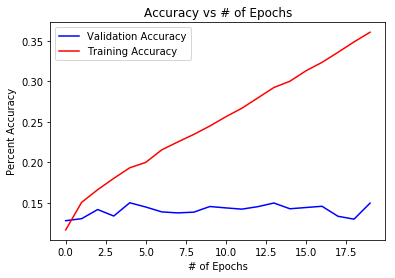

In [22]:
plot_accuracy()#base model
#No batch normalization, and no drop out layers 

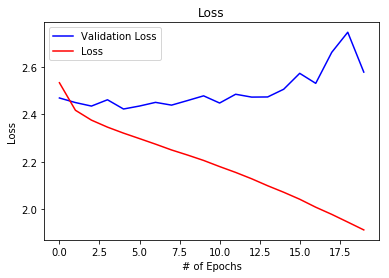

In [39]:
plot_loss()#base model

In [32]:
model.evaluate_generator(generator= test_generator,
                         steps= STEP_SIZE_TEST,
                         verbose= 1)

#Accuracy of 15% with loss of 2.56

 96/168 [================>.............] - ETA: 27s

C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:780: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 50331652 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 201326612 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 67108884 bytes but only got 30536. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\ar344\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3484759239 bytes bu

168/168 [==============================] - 69s 409ms/step


[2.5650981622082845, 0.15327380956815823]

In [34]:
model.metrics_names

['loss', 'acc']

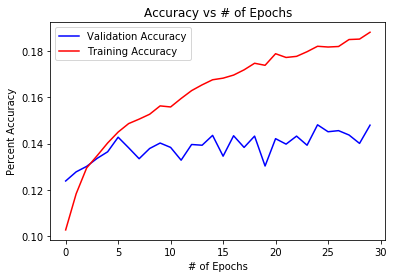

In [72]:
plot_accuracy()

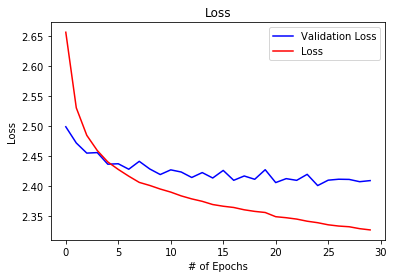

In [73]:
plot_loss()

In [35]:
model.save("base_model.h5")
model.save_weights("base_model_weights.h5")

## Using Model To Make a Prediction 

In [4]:
def predictoneimage_cnn(model, path):
    img = load_img(path, target_size=(160, 160))
    print(type(img))
    plt.imshow(img)
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)
    predict = model.predict(img)
    return predict

In [7]:
model = load_model('base_model.h5')

Instructions for updating:
Use tf.cast instead.


<class 'PIL.Image.Image'>


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node block1_conv1_1/convolution}}]]
	 [[{{node dense_4_1/Softmax}}]]

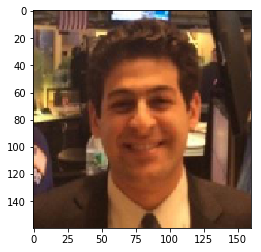

In [8]:
predictoneimage_cnn(model, 'alex_test.JPG')

In [74]:
train_generator.class_indices

{'[10 - 15)': 0,
 '[15 - 20)': 1,
 '[20 - 25)': 2,
 '[25 - 30)': 3,
 '[30 - 35)': 4,
 '[35 - 40)': 5,
 '[40 - 45)': 6,
 '[45 - 50)': 7,
 '[50 - 55)': 8,
 '[55 - 60)': 9,
 '[60 - 65)': 10,
 '[65 - 70)': 11,
 '[70 - 80)': 12}

According to this prediction Alex has a 20% probability of being in the 20 - 25 age range, and a 25% probability of being
in the 45-50 age range. Not great